In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
# Define the Physics-Informed Neural Network class
class PhysicsInformedNN:
    def __init__(self, x0, u0, x1, layers, dt, lb, ub, q):
        self.lb = torch.tensor(lb, dtype=torch.float32)
        self.ub = torch.tensor(ub, dtype=torch.float32)
        
        self.x0 = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
        self.x1 = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
        self.u0 = torch.tensor(u0, dtype=torch.float32)
        
        self.dt = torch.tensor(dt, dtype=torch.float32)
        self.q = max(q, 1)

        # Initialize NN
        self.model = self.build_model(layers)

        # Load IRK weights
        tmp = np.loadtxt('IRK_weights/Butcher_IRK%d.txt' % (q), ndmin=2).astype(np.float32)
        self.IRK_weights = torch.tensor(tmp[:q**2 + q].reshape((q + 1, q)), dtype=torch.float32)
        self.IRK_times = torch.tensor(tmp[q**2 + q:], dtype=torch.float32)

        # Optimizers
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=1e-3)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), lr=1e-2, max_iter=100000, tolerance_grad=1e-5, tolerance_change=1e-9, history_size=50, line_search_fn='strong_wolfe')
        self.loss_fn = nn.MSELoss()

    def build_model(self, layers):
        layers_list = []
        for i in range(len(layers) - 1):
            layers_list.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                layers_list.append(nn.Tanh())
        return nn.Sequential(*layers_list)

    def forward(self, x):
        x_normalized = 2.0 * (x - self.lb) / (self.ub - self.lb) - 1.0
        return self.model(x_normalized)

    def fwd_gradients(self, U, x):
        g = torch.autograd.grad(U, x, grad_outputs=torch.ones_like(U), create_graph=True)[0]
        return g

    def net_U0(self, x):
        U1 = self.forward(x)
        U = U1[:, :-1]
        U_x = self.fwd_gradients(U, x)
        U_xx = self.fwd_gradients(U_x, x)
        F = 5.0 * U - 5.0 * U**3 + 0.0001 * U_xx
        U0 = U1 - self.dt * torch.matmul(F, self.IRK_weights.T)
        return U0

    def train(self, nIter):
        for it in range(nIter):
            self.optimizer_Adam.zero_grad()
            U0_pred = self.net_U0(self.x0)

            loss = self.loss_fn(U0_pred, self.u0)
            loss.backward()
            self.optimizer_Adam.step()

            if it % 1000 == 0:
                print(f"Iter {it}, Loss: {loss.item():.3e}")

        # Switch to L-BFGS optimizer
        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
            U0_pred = self.net_U0(self.x0)
            loss = self.loss_fn(U0_pred, self.u0)
            if loss.requires_grad:
                loss.backward()
            print(f"L-BFGS Loss: {loss.item():.3e}")
            return loss

        self.optimizer_LBFGS.step(closure)
        print("BFGS Optimization Complete")

    def predict(self, x_star):
        self.model.eval()
        with torch.no_grad():
            U1_star = self.forward(torch.tensor(x_star, dtype=torch.float32))
        return U1_star


In [5]:
if __name__ == "__main__":
    q = 100
    layers = [1, 200, 200, 200, 200, q + 1]
    lb = [-1.0]
    ub = [1.0]

    N = 200

    data = loadmat('AC.mat')

    t = data['tt'].flatten()[:, None]  # T x 1
    x = data['x'].flatten()[:, None]  # N x 1
    Exact = np.real(data['uu']).T  # T x N

    idx_t0 = 20
    idx_t1 = 180
    dt = t[idx_t1] - t[idx_t0]

    # Initial data
    noise_u0 = 0.0
    idx_x = np.random.choice(Exact.shape[1], N, replace=False)
    x0 = x[idx_x, :]
    u0 = Exact[idx_t0:idx_t0 + 1, idx_x].T
    u0 = u0 + noise_u0 * np.std(u0) * np.random.randn(u0.shape[0], u0.shape[1])

    # Boundary data
    x1 = np.vstack((lb, ub))

    # Test data
    x_star = x

    model = PhysicsInformedNN(x0, u0, x1, layers, dt, lb, ub, q)
    model.train(10000)

    U1_pred = model.predict(x_star)

    error = np.linalg.norm(U1_pred[:, -1].numpy() - Exact[idx_t1, :], 2) / np.linalg.norm(Exact[idx_t1, :], 2)
    print(f"Error: {error:.3e}")


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200, 101])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iter 0, Loss: 2.104e-01
Iter 1000, Loss: 1.371e-03
Iter 2000, Loss: 1.390e-03
Iter 3000, Loss: 3.700e-04
Iter 4000, Loss: 2.079e-04
Iter 5000, Loss: 1.687e-04
Iter 6000, Loss: 5.561e-04
Iter 7000, Loss: 5.835e-05
Iter 8000, Loss: 2.074e-05
Iter 9000, Loss: 1.205e-05
L-BFGS Loss: 1.450e-05
L-BFGS Loss: 1.367e-05
L-BFGS Loss: 8.856e-06
L-BFGS Loss: 8.837e-06
L-BFGS Loss: 8.751e-06
L-BFGS Loss: 8.006e-06
L-BFGS Loss: 7.993e-06
L-BFGS Loss: 7.933e-06
L-BFGS Loss: 7.434e-06
L-BFGS Loss: 7.428e-06
L-BFGS Loss: 7.401e-06
L-BFGS Loss: 7.208e-06
L-BFGS Loss: 7.205e-06
L-BFGS Loss: 7.193e-06
L-BFGS Loss: 7.110e-06
L-BFGS Loss: 7.108e-06
L-BFGS Loss: 7.099e-06
L-BFGS Loss: 7.059e-06
BFGS Optimization Complete
Error: 3.179e-01


/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_9701/180447917.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('$t = %.2f$' % (t[idx_t0]), fontsize=10)
/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_9701/180447917.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize=10)


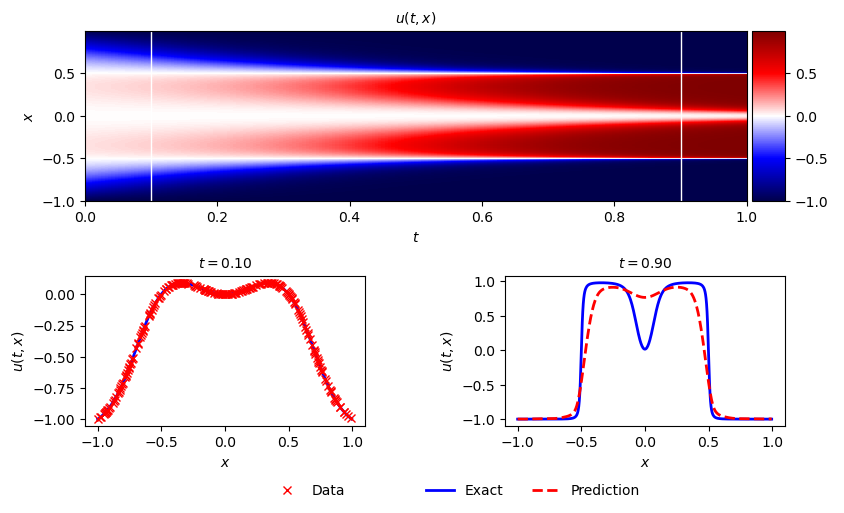

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')

####### Row 0: h(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06, bottom=1 - 1 / 2 + 0.1, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact.T, interpolation='nearest', cmap='seismic',
            extent=[t.min(), t.max(), x_star.min(), x_star.max()],
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[idx_t0] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[idx_t1] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$u(t,x)$', fontsize=10)

####### Row 1: h(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1 - 1 / 2 - 0.05, bottom=0.15, left=0.15, right=0.85, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[idx_t0, :], 'b-', linewidth=2)
ax.plot(x0, u0, 'rx', linewidth=2, label='Data')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = %.2f$' % (t[idx_t0]), fontsize=10)
ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
ax.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, frameon=False)

ax = plt.subplot(gs1[0, 1])
ax.plot(x, Exact[idx_t1, :], 'b-', linewidth=2, label='Exact')
ax.plot(x_star, U1_pred[:, -1], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize=10)
ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])

ax.legend(loc='upper center', bbox_to_anchor=(0.1, -0.3), ncol=2, frameon=False)

plt.show()